## 계층적 멀티 에이전트 팀(Hierarchial Agent Team)

시스템에 더 많은 에이전트를 추가하면 슈퍼바이저가 모든 에이전트를 관리하기 너무 어려워질 수 있습니다. 슈퍼바이저가 다음에 호출할 에이전트에 대해 잘못된 결정을 내리기 시작하거나, 단일 슈퍼바이저가 추적하기에는 컨텍스트가 너무 복잡해질 수 있습니다. 즉, 애초에 멀티 에이전트 아키텍처를 채택하게 된 것과 동일한 문제가 발생하게 됩니다.

이를 해결하기 위해 시스템을 **계층적으로** 설계할 수 있습니다. 예를 들어, 개별 슈퍼바이저가 관리하는 전문화된 에이전트 팀을 별도로 만들고, 최상위 슈퍼바이저가 팀을 관리하도록 할 수 있습니다.

- 참고 자료: https://wikidocs.net/270691
- 관련 논문: https://arxiv.org/abs/2308.08155

## 환경 설정

In [1]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

In [46]:
# 스트리밍 에이전트 출력을 깔끔하게 렌더링하기 위해
# pretty_print_messages 헬퍼를 사용할 것입니다
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update.get("messages", []))
        if messages and len(messages) > 0 and last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

## 리서치 팀(Research Team)

리서치 팀은 `search agent`와 `research_agent`라는 두 개의 작업자를 가집니다. 작업자 에이전트를 생성하고 팀 슈퍼바이저를 생성합니다.

### 리서치 도구

In [3]:
from langchain_tavily import TavilySearch

# 웹 검색 도구 정의
web_search_tool = TavilySearch(max_results=5)

In [ ]:
# 웹 페이지에서 세부 정보를 스크래핑하기 위한 도구 정의
from typing import List
from langchain_core.tools import tool
from langchain_community.document_loaders import WebBaseLoader


@tool
def scrape_webpages(urls: List[str]):
    """제공된 웹 페이지에서 상세 정보를 추출하기 위해 사용하십시오."""

    loader = WebBaseLoader(
        web_paths=urls,
        header_template={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/110",
        },
    )
    docs = loader.load()

    return "\n".join(
        [
            f'<Document source="{doc.metadata.get("source", "")}" title="{doc.metadata.get("title", "")}">{doc.page_content}</Document>'
            for doc in docs
        ]
    )


In [ ]:
scrape_webpages.invoke(
    input={"urls": ["https://langchain-ai.github.io/langgraph/concepts/multi_agent/"]}
)

'<Document source="https://langchain-ai.github.io/langgraph/concepts/multi_agent/" title="Overview">\n\n\n\n\n\n\n\n\n\n\n\nOverview\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\n            \n            \nThese docs will be deprecated and removed with the release of LangGraph v1.0 in October 2025. Visit the v1.0 alpha docs\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            LangGraph\n          \n\n\n\n            \n              Overview\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            Initializing search\n          \n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n\n\n          \n  \n  \n    \n  \n  Get started\n\n        \n\n\n\n          \n  \n  \n    \n  \n  Guides\n\n        \n\n\n\n          \n  \n  \n    \n  \n  Reference\n\n        \n\n\n\n          \n  \n  \n    \n  \n  Examples\n\n        \n\n\n\n          \n  \n  \n    \n  \n  Additional res

### 리서치팀 그래프 상태 정의

In [27]:
from typing import Annotated
from langgraph.graph.message import MessagesState


class ResearchState(MessagesState):
    team_members: Annotated[list[str], "팀원 에이전트 목록"]
    next_agent: Annotated[str, "다음 작업자"]

## 에이전트 노드 생성

In [34]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph.state import CompiledStateGraph
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


# 에이전트 노드 생성 함수
def create_agent_node(agent: CompiledStateGraph, name: str):
    def agent_node(state):
        response = agent.invoke(state)
        answer = response["messages"][-1].content
        return {"messages": [HumanMessage(content=answer, name=name)]}

    return agent_node


# 슈퍼파이저 에이전트 생성 함수
def create_team_supervisor(model_name, system_prompt, members: list[str]):
    # 다음 작업자 선택 옵션 목록 정의
    options_for_next_agent = ["FINISH"] + members

    class RouteResponse(BaseModel):
        """
        워크플로우 라우팅 응답 모델

        현재 에이전트가 작업을 완료한 후, 다음에 실행될 에이전트를 결정하거나
        전체 워크플로우를 종료하기 위한 응답 모델입니다.
        """

        next_agent: Annotated[
            Literal[*options_for_next_agent],
            Field(
                ...,
                description="다음으로 라우팅할 에이전트의 이름 또는 'FINISH'를 지정합니다. "
                "사용 가능한 값:\n"
                "- 에이전트 이름: 해당 에이전트로 작업을 전달\n"
                "- 'FINISH': 모든 작업이 완료되어 워크플로우를 종료\n"
                "현재 작업 상태와 요구사항을 기반으로 가장 적합한 다음 단계를 선택하세요.",
            ),
        ]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt
                + "\nGiven the conversation above, who should act next agent? "
                "\nOr should we FINISH? Select one of: {options}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(options=", ".join(options_for_next_agent))

    llm = ChatOpenAI(model=model_name, temperature=0)

    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    return supervisor_chain


# 검색 에이전트
search_agent = create_react_agent("openai:gpt-4.1-mini", tools=[web_search_tool])
search_node = create_agent_node(search_agent, name="Searcher")

# 웹 스크래핑 노드
web_scraping_agent = create_react_agent("openai:gpt-4.1-mini", tools=[scrape_webpages])
web_scraping_node = create_agent_node(web_scraping_agent, name="WebScraper")

# Supervisor 에이전트
supervisor_agent = create_team_supervisor(
    "gpt-4.1-mini",
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Searcher", "WebScraper"],
)


def supervisor(state: ResearchState):
    response = supervisor_agent.invoke(state["messages"])
    return {"next_agent": response.next_agent}

### 리서치팀 그래프 생성

In [36]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver


def get_next_node(state: ResearchState):
    return state["next_agent"]


research_builder = StateGraph(ResearchState)

research_builder.add_node("Searcher", search_node)
research_builder.add_node("WebScraper", web_scraping_node)
research_builder.add_node("Supervisor", supervisor)

research_builder.add_edge("Searcher", "Supervisor")
research_builder.add_edge("WebScraper", "Supervisor")
research_builder.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "Searcher": "Searcher",
        "WebScraper": "WebScraper",
        "FINISH": END,
    },
)

research_builder.set_entry_point("Supervisor")

research_graph = research_builder.compile(checkpointer=MemorySaver())


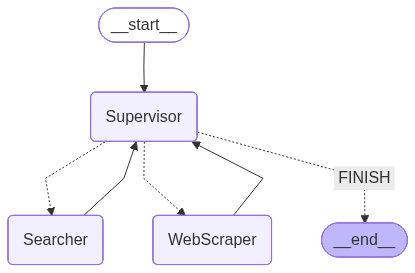

In [37]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [41]:
from langgraph.graph.state import CompiledStateGraph
from langchain_core.runnables import RunnableConfig
from random import random


def run_graph(graph: CompiledStateGraph, message: str, recursive_limit: int = 50):
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random()}
    )

    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    for chunk in graph.stream(inputs, config):
        pretty_print_messages(chunk)

    return graph.get_state(config).values

In [47]:
output = run_graph(
    research_graph,
    "https://finance.naver.com/news 의 주요 뉴스 정리해서 출력해줘. 출처(URL) 도 함께 출력해줘.",
)

Update from node Supervisor:




Update from node WebScraper:


================================ Human Message =================================
Name: WebScraper

네이버 금융 뉴스 주요 뉴스 정리입니다:

1. 반도체 실적 기대 vs 미중·셧다운 리스크 [주간증시전망]
2. 양자컴퓨팅 ETF 20%대 급등..中 테크 일제히 약세 [ETF 스퀘어]
3. “이러니 주가 안오를 수 있겠나”…AI·코인 다 가진 ‘이 기업’ 한달새 78% 급등
4. 트럼프 ‘암초’ 천당·지옥 오간 비트코인…“중국 추가 보복이 관건” [가상자산 나침반]
5. 닛케이 4만8000선 돌파 '다카이치 랠리'...日 반도체 ETF 20% 급등
6. 일본 ‘메타플래닛’·홍콩 ‘문’…아시아판 스트래티지 만든다는 이 남자의 전략

출처: https://finance.naver.com/news


Update from node Supervisor:






In [48]:
print(output["messages"][-1].content)

네이버 금융 뉴스 주요 뉴스 정리입니다:

1. 반도체 실적 기대 vs 미중·셧다운 리스크 [주간증시전망]
2. 양자컴퓨팅 ETF 20%대 급등..中 테크 일제히 약세 [ETF 스퀘어]
3. “이러니 주가 안오를 수 있겠나”…AI·코인 다 가진 ‘이 기업’ 한달새 78% 급등
4. 트럼프 ‘암초’ 천당·지옥 오간 비트코인…“중국 추가 보복이 관건” [가상자산 나침반]
5. 닛케이 4만8000선 돌파 '다카이치 랠리'...日 반도체 ETF 20% 급등
6. 일본 ‘메타플래닛’·홍콩 ‘문’…아시아판 스트래티지 만든다는 이 남자의 전략

출처: https://finance.naver.com/news


## 문서 작성팀

### 문서 작성 도구

In [ ]:
from pathlib import Path
from typing import Dict, Optional, List
from typing_extensions import Annotated


# 작업 디렉토리
WORKING_DIRECTORY = Path("./tmp")
WORKING_DIRECTORY.mkdir(exist_ok=True)


# 아웃라인 생성 및 파일로 저장
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    # 주어진 파일 이름으로 아웃라인을 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# 문서 읽기
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    # 시작 줄이 지정되지 않은 경우 기본값 설정
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


# 문서 쓰기 및 저장
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    # 주어진 파일 이름으로 문서 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


# 문서 편집
@tool
def edit_document(
    file_name: Annotated[str, "File path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "File path of the edited document."]:
    """Edit a document by inserting text at specific line numbers."""

    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    # 삽입할 텍스트를 정렬하여 처리
    sorted_inserts = sorted(inserts.items())

    # 지정된 줄 번호에 텍스트 삽입
    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    # 편집된 문서를 파일에 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


In [23]:
from langchain_experimental.tools import PythonREPLTool

python_repl_tool = PythonREPLTool()